In [4]:
from eval_1022 import *
import json
import numpy as np

# qids = [
#     "d5c745d00dba11ecb1e81171463288e9",
#     "d5c0f39c0dba11ecb1e81171463288e9",
#     "d5c164b20dba11ecb1e81171463288e9",
#     "d5cbb1880dba11ecb1e81171463288e9",
#     "d5c747c40dba11ecb1e81171463288e9",
#     "d5c312260dba11ecb1e81171463288e9",
#     "d5c3fdbc0dba11ecb1e81171463288e9",
#     "d5c93d400dba11ecb1e81171463288e9",
#     "d5c506940dba11ecb1e81171463288e9",
#     "d5cacb920dba11ecb1e81171463288e9",
#     "d5ca118e0dba11ecb1e81171463288e9",
#     "d5c2f8e00dba11ecb1e81171463288e9",
#     "d5c944fc0dba11ecb1e81171463288e9"
# ]


exp_name = "webqa_qa_check"
data_dir = "/home/pcarragh/dev/webqa/MultiModalQA/data/"
data_dir += "WebQA_train_val_obj_v2.json"

with open(data_dir, 'r') as f:
    eval_data = json.load(f)
# filter by qids
eval_data = {k: v for k, v in eval_data.items() if eval_data[k]['split'] == 'val'}

perturbation_path = "/home/pcarragh/dev/webqa/image_gen_val/val_images_perturbed_gpt_obj_lama"
eval_data = {k: v for k, v in eval_data.items() if any([k in img_file for img_file in os.listdir(perturbation_path)])}
two_image_questions = {k:eval_data[k]['Q'] for k in tqdm(list(eval_data.keys())) if len(eval_data[k]["img_posFacts"]) == 2}

100%|██████████| 1325/1325 [00:00<00:00, 875327.26it/s]


In [10]:
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model, eval
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init

disable_torch_init()
model_path = "liuhaotian/llava-v1.5-7b"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, None, model_name
)

def llava_eval_on_webqa_sample(question, image_files):
    args = type('Args', (), {
        "model_path": model_path,
        "model_base": None,
        "model_name": model_name,
        "query": question,
        "conv_mode": None,
        "image_file": image_files,
        "sep": ",",
        "temperature": 0,
        "top_p": None,
        "num_beams": 1,
        "max_new_tokens": 512,
    })()

    return eval(tokenizer, model, image_processor,  args)

def get_prompt(key, img_title):
    return f"<image-placeholder> \n Caption: {img_title} \n Question: has this image been altered in any way?"


def accuracy_agg_results(llava_results):
    return np.mean([v for k, l in llava_results.items() for v in l])

# def accuracy_agg_results(qa_results):
#     single_image_keys = [k for k in qa_results.keys() if len(eval_data[k]['img_posFacts']) == 1]
#     two_image_keys = [k for k in qa_results.keys() if len(eval_data[k]['img_posFacts']) == 2]

#     single_acc = np.mean([PR_avg for key, (F1_avg, F1_max, EM, RE_avg, PR_avg) in qa_results.items() if key in single_image_keys])
#     two_image_acc = np.mean([PR_avg for key, (F1_avg, F1_max, EM, RE_avg, PR_avg) in qa_results.items() if key in two_image_keys])
#     avr_acc = np.mean([PR_avg for key, (F1_avg, F1_max, EM, RE_avg, PR_avg) in qa_results.items()])
#     return (single_acc, two_image_acc, avr_acc)

/home/pcarragh/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


### LLAVA alteration check on original images that have matching perturbations

In [8]:
from tqdm import tqdm

llava_results_baseline = {}
for k in tqdm(list(eval_data.keys())):
    llava_results_baseline[k] = []
    for img in eval_data[k]['img_posFacts']:
        image_files = str(img['image_id'])
        question = get_prompt(k, img['title'])
        try:
            answer = llava_eval_on_webqa_sample(question, image_files)
        except:
            continue
        llava_results_baseline[k].append(int('no' in answer.lower()))


print(accuracy_agg_results(llava_results_baseline))

  0%|          | 0/1325 [00:00<?, ?it/s]/home/pcarragh/miniconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/pcarragh/miniconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 1325/1325 [19:58<00:00,  1.11it/s]

0.7730420884389984


### Bad perturbations

In [9]:
llava_results_perturbed = {}
for k in tqdm(list(eval_data.keys())):
    llava_results_perturbed[k] = []
    for img in eval_data[k]['img_posFacts']:
        image_id = eval_data[k]['img_posFacts'][0]['image_id']
        image_files = f"{perturbation_path}/{str(image_id)}_{k}.jpeg"
        if os.path.exists(image_files):
            question = get_prompt(k, img['title'])
            try:
                answer = llava_eval_on_webqa_sample(question, image_files)
            except:
                continue
            llava_results_perturbed[k].append(int('yes' in answer.lower()))


print(accuracy_agg_results(llava_results_perturbed))

  0%|          | 0/1325 [00:00<?, ?it/s]/home/pcarragh/miniconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/pcarragh/miniconda3/envs/llava/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 1325/1325 [27:59<00:00,  1.27s/it] 


ValueError: not enough values to unpack (expected 5, got 1)

In [11]:
print(accuracy_agg_results(llava_results_perturbed))

0.5739455419113721


### Blank image alteration

In [12]:
llava_results_blank = {}
for k in tqdm(list(eval_data.keys())):
    llava_results_blank[k] = []
    for img in eval_data[k]['img_posFacts']:
        image_files = 'playground/counterfactual_exp/BLANK.jpg,playground/counterfactual_exp/BLANK.jpg'
        question = get_prompt(k, img['title'])
        try:
            answer = llava_eval_on_webqa_sample(question, image_files)
        except:
            continue
        llava_results_blank[k].append(int('yes' in answer.lower()))


print(accuracy_agg_results(llava_results_blank))

100%|██████████| 1325/1325 [22:30<00:00,  1.02s/it]

0.5284810126582279


In [14]:
import pandas as pd

baseline_accs = accuracy_agg_results(llava_results_baseline)
blank_accs = accuracy_agg_results(llava_results_blank)
perturbed_accs = accuracy_agg_results(llava_results_perturbed)

columns = ['experiment name', 'single_image', 'two_image', 'average']
accuracy_agg_df = pd.DataFrame(columns=columns)
accuracy_agg_df['experiment name'] = ['baseline(no)', 'blank(yes)', 'perturbed(yes)']
accuracy_agg_df['single_image'] = [baseline_accs[0], blank_accs[0], perturbed_accs[0]]
accuracy_agg_df['two_image'] = [baseline_accs[1], blank_accs[1], perturbed_accs[1]]
accuracy_agg_df['average'] = [baseline_accs[2], blank_accs[2], perturbed_accs[2]]
accuracy_agg_df.to_csv(f"results/{exp_name}.csv", index=False)
accuracy_agg_df


,experiment name,single_image,two_image,average
0,baseline,0.723977,0.729885,0.725175
1,blank,0.298977,0.000000,0.238345
2,perturbed_original_label,0.126263,0.000000,0.101863
3,perturbed_generated_label,0.734488,0.000000,0.592549


In [89]:
# compare perturbed and original image side by side
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

def display_images(image1, mask, image2, q, segment_prompt, infill_prompt, save=True):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    # reduce image dimensions to fit in plot    
    ax[0].imshow(image1)
    # ax[1].imshow(mask)
    ax[2].imshow(image2)
    ax[0].set_title('Segment Prompt: ' + segment_prompt)
    ax[1].set_title('Mask')
    ax[2].set_title('Infill Prompt: ' + infill_prompt)
    plt.suptitle(q, fontsize = 17)
    # remove gap between title and images
    plt.subplots_adjust(top=0.9, wspace=0.03)
    # plt.tight_layout(rect=[0, 0, 1, 0.9])
    for a in ax:
        a.axis('off')
    if save:
        plt.savefig(f"examples/{infill_prompt}_perturbed.png", bbox_inches='tight', dpi=300)    
    plt.show()
    
perturbation_detected_keys = [(k, img) for k,l in llava_results_perturbed.items() for img, res in enumerate(l) if res == 1 and eval_data[k]['Qcate'].lower() == 'yesno']
perturbation_undetected_keys = [(k, img) for k,l in llava_results_perturbed.items() for img, res in enumerate(l) if res == 0 and eval_data[k]['Qcate'].lower() == 'yesno']

False


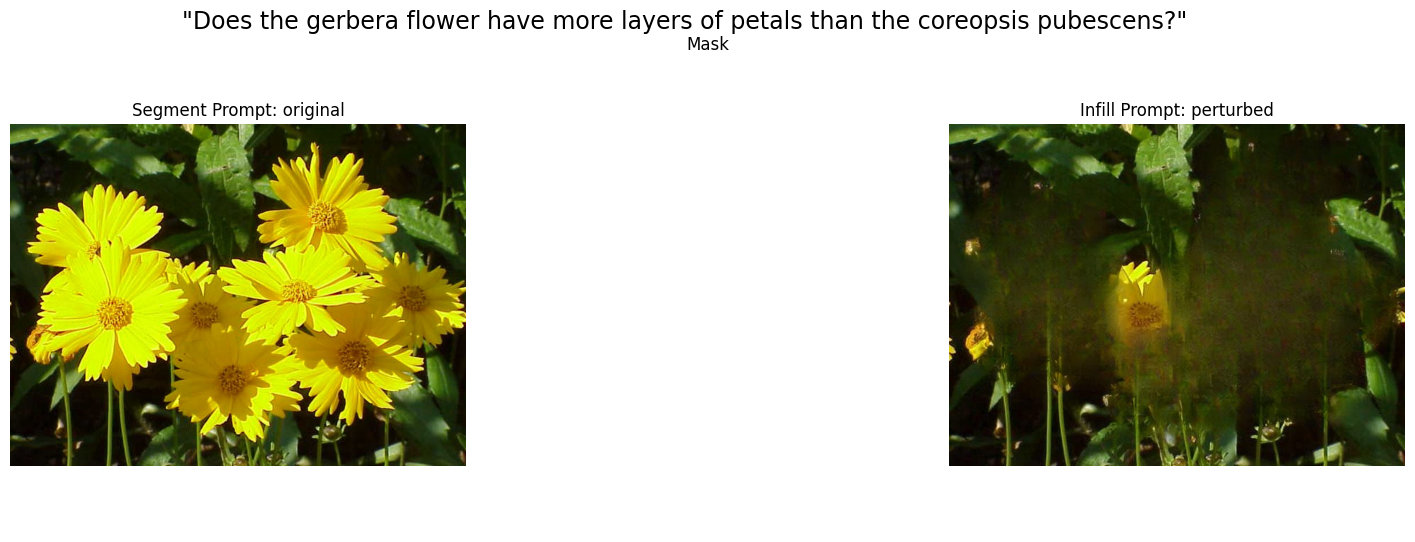

In [207]:
from llava.eval.run_llava import load_images

# example_keys = [(k, id) for k, id in perturbation_detected_keys if len(eval_data[k]['img_posFacts']) == 1]
example_keys = perturbation_detected_keys

key, id = example_keys[random.randint(0, len(example_keys))]
image_id = eval_data[key]['img_posFacts'][id]['image_id']
imgs = load_images([image_id, f"{perturbation_path}/{str(image_id)}_{key}.jpeg"])

def image_equals(img1, img2):
    if img1.size != img2.size:
        return "Wrong size"
    return np.allclose(np.array(img1), np.array(img2))

print(image_equals(imgs[0], imgs[1]))
display_images(imgs[0], None, imgs[1], eval_data[key]['Q'], "original", "perturbed", save=False)

In [209]:
print(len(perturbation_detected_keys))
# dump keys to csv
import csv
with open(f"results/counterfactual_qa_check.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerows(perturbation_detected_keys)

787


: 